In [1]:
import pandas as pd

In [15]:
# import of adj_mat
# import of nodes_cluster
# import of news_data
# import of crypto_data

# Import section

## adj_mat

In [2]:
adj_mat = pd.read_csv('../Griffin_data/Adjacency_Matrix_Output.csv', index_col='Unnamed: 0')

In [3]:
adj_mat.loc[adj_mat['src'] == 'aaveaave']

#df.loc[df['column_name'] == some_value]

,src,dst,date,cluster_src,mes_sent,mes_received,mes_total,contr_index,sentiment_avg,emoti_avg,compl_avg,neighbours,cluster_dst,cluster_equal,neighbours_!cluster,neighbours_cluster
12815,aaveaave,yerbamatenft,2021-11-29 00:00:00,C7,0,1,1,-1.0,NaN,NaN,NaN,29,C7,True,12,17
12816,aaveaave,gonzalosilman,2021-11-29 00:00:00,C7,0,1,1,-1.0,NaN,NaN,NaN,29,C7,True,12,17
12817,aaveaave,0xyeeeew,2021-12-06 00:00:00,C7,0,1,1,-1.0,NaN,NaN,NaN,29,C7,True,12,17
12818,aaveaave,morales_eth,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C2,True,12,17
12819,aaveaave,morales_eth,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C7,False,12,17
12820,aaveaave,dogecoi58389808,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C2,True,12,17
12821,aaveaave,dogecoi58389808,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C7,False,12,17
12822,aaveaave,elonesqandar,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C2,True,12,17
12823,aaveaave,elonesqandar,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C7,False,12,17
12824,aaveaave,jasoncrypto95,2021-12-26 00:00:00,C2,0,1,1,-1.0,NaN,NaN,NaN,29,C2,True,12,17


In [86]:
adj_mat

,src,dst,date,cluster_src,mes_sent,mes_received,mes_total,contr_index,sentiment_avg,emoti_avg,compl_avg,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst,cluster_equal
0,000126373b,oh73hh,2021-12-20 00:00:00,C2,1,0,1,1.0,NaN,NaN,NaN,4,2,0,C2,True
1,000126373b,oh73hh,2021-12-20 00:00:00,C2,1,0,1,1.0,NaN,NaN,NaN,4,0,2,C7,False
2,000126373b,oh73hh,2021-12-20 00:00:00,C7,1,0,1,1.0,0.159375,0.293872,4.385481,4,0,2,C2,False
3,000126373b,oh73hh,2021-12-20 00:00:00,C7,1,0,1,1.0,0.159375,0.293872,4.385481,4,2,0,C7,True
4,0001_yousef,dogelon_muskk,2021-12-20 00:00:00,C7,1,0,1,1.0,NaN,NaN,NaN,11,10,0,C7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215975,zzzaferrr,ellocobielsaa,2021-11-29 00:00:00,C0,0,1,1,-1.0,NaN,NaN,NaN,2,0,1,C7,False
215976,zzzneji,peitosdotorao,2021-12-12 00:00:00,C3,0,1,1,-1.0,NaN,NaN,NaN,4,2,0,C3,True
215977,zzzneji,peitosdotorao,2021-12-12 00:00:00,C3,0,1,1,-1.0,NaN,NaN,NaN,4,0,2,C9,False
215978,zzzneji,peitosdotorao,2021-12-12 00:00:00,C9,0,1,1,-1.0,NaN,NaN,NaN,4,0,2,C3,False


In [4]:
adj_mat = adj_mat[['src', 'dst', 'date', 'cluster_src', 'neighbours', 'neighbours_cluster', 'neighbours_!cluster', 'cluster_dst']]

In [5]:
adj_mat

,src,dst,date,cluster_src,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst
0,000126373b,oh73hh,2021-12-20 00:00:00,C2,4,2,2,C2
1,000126373b,oh73hh,2021-12-20 00:00:00,C2,4,2,2,C7
2,000126373b,oh73hh,2021-12-20 00:00:00,C7,4,2,2,C2
3,000126373b,oh73hh,2021-12-20 00:00:00,C7,4,2,2,C7
4,0001_yousef,dogelon_muskk,2021-12-20 00:00:00,C7,11,10,1,C7
...,...,...,...,...,...,...,...,...
215975,zzzaferrr,ellocobielsaa,2021-11-29 00:00:00,C0,2,1,1,C7
215976,zzzneji,peitosdotorao,2021-12-12 00:00:00,C3,4,2,2,C3
215977,zzzneji,peitosdotorao,2021-12-12 00:00:00,C3,4,2,2,C9
215978,zzzneji,peitosdotorao,2021-12-12 00:00:00,C9,4,2,2,C3


## nodes_cluster

## news_data

## crypto_data

In [1]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
from yahoofinancials import YahooFinancials
#input value, data from yahoo finance
value = input("Please enter the currency: \n")
ticker = yf.Ticker(f'{value}-USD')
df_ta = ticker.history(period="5y")
df_ta.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
#add index value
p = df_ta.index.values
df_ta.insert( 0, column="Date",value = p)
#Calculate RSI
delta = df_ta['Close'].diff(1) #difference from the previous day
delta = delta.dropna()
#get the positive gains(up) and negative gains(down)
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
#Get the time period 14 days
period = 14
#calculate the average gain and loss
AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = abs(down.rolling(window=period).mean())
#Calculate RSI
RS = AVG_Gain / AVG_Loss #relative strength
#RSI
RSI = 100.0 - (100.0/(1.0 + RS))
#Put it all together
new_df = pd.DataFrame()
new_df['Close'] = df_ta['Close']
new_df['RSI'] = RSI
new_df
#Get Buy and Sell Signals
conditions = [
    (new_df['RSI'] < 80) & (new_df['RSI'] > 20),
    (new_df['RSI'] < 80),
    (new_df['RSI'] > 20)]
choices = [0, -2, 2]
df_ta['signal_rsi'] = np.select(conditions, choices, default='0')
#Bollinger Bands indicator
period= 20
#Simple Moving Average
df_ta['SMA'] = df_ta['Close'].rolling(window=period).mean()
#Standard deviation
df_ta['STD'] = df_ta['Close'].rolling(window=period).std()
#upper band
df_ta['Upper'] = df_ta['SMA'] + (df_ta['STD']*2)
#lower band
df_ta['Lower'] = df_ta['SMA'] - (df_ta['STD']*2)
#Create Signal Value
conditions = [
    (df_ta.Lower > df_ta.Close) & (df_ta.Upper < df_ta.Close),
    (df_ta.Lower > df_ta.Close),
    (df_ta.Upper < df_ta.Close)]
choices = [0, 2, -2]
df_ta['signal_bb'] = np.select(conditions, choices, default='0')
df_ta = df_ta.dropna()
#On Balance Volume indicator
df_ta['Daily Returns'] = df_ta['Close'].pct_change()
df_ta['signal_obv'] = 0
df_ta.loc[df_ta['Daily Returns'] > 0, 'signal_obv'] = 2
df_ta.loc[df_ta['Daily Returns'] < 0, 'signal_obv'] = -2
df_ta.dropna(inplace= True)
#MVA indicator
#Create the simple MVA
def SMA(data, period = 30, column ='Close'):
    return data[column].rolling(window=period).mean()
#Creating the Exponential MVA
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()
#Calculate MVA Convergence/Divergence
def MACD(data, period_long=28, period_short=12, period_signal=9, column='Close'):
    #calculate the short term exponential MVA
    ShortEMA = EMA(data, period_short, column=column)
    #calculate the long term exponential MVA
    LongEMA = EMA(data, period_long, column=column)
    #calculate the MVA Convergence/Divergence MACD
    data['MACDA'] = ShortEMA - LongEMA
    #calculate the signal line
    data['Signal_Line'] = EMA(data, period_signal, column='MACD')
    return data
df_ta['SMA'] = SMA(df_ta)
df_ta['EMA'] = EMA(df_ta)
#Create a Simple Moving Average indicator
def SMA(data, period = 30, column = 'Close'):
    return data[column].rolling(window=period).mean()
#Create two new columns to store 20 and 50 day SMA
df_ta['SMA20']=SMA(df_ta, 20)
df_ta['SMA50']=SMA(df_ta, 50)
#Get Buy and Sell Signals
df_ta['signal_mva'] = np.where(df_ta['SMA20']> df_ta['SMA50'], 2, -2)
# Delete redundant data
df_ta.drop(['SMA', 'STD', 'Upper', 'Lower','Daily Returns', 'EMA','SMA20','SMA50'], axis=1, inplace=True)
#prepare datatype
df_ta['signal_rsi'] = df_ta['signal_rsi'].astype('int')
df_ta['signal_bb'] = df_ta['signal_bb'].astype('int')
df_ta['signal_mva'] = df_ta['signal_mva'].astype('int')
df_ta['signal_obv'] = df_ta['signal_obv'].astype('int')
#add calculated average
zaehler =  df_ta.apply(lambda x: (0.3 * x['signal_bb']) + (0.3 * x['signal_mva']) + (0.2 * x['signal_obv']) +(0.2 * x['signal_rsi']), axis=1)
df_ta['calculated_average'] = zaehler / 1
#Plot Frame
df_ta

Please enter the currency: 
BTC


,Date,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
Date,,,,,,,,
2017-02-09,2017-02-09,994.382996,407220000,0,0,-2,-2,-1.0
2017-02-10,2017-02-10,988.674011,190452000,0,0,-2,-2,-1.0
2017-02-11,2017-02-11,1004.450012,102261000,0,0,2,-2,-0.2
2017-02-12,2017-02-12,999.181030,67530000,0,0,-2,-2,-1.0
2017-02-13,2017-02-13,990.642029,100607000,0,0,-2,-2,-1.0
...,...,...,...,...,...,...,...,...
2022-01-16,2022-01-16,43113.878906,17902097845,0,0,-2,-2,-1.0
2022-01-17,2022-01-17,42250.550781,21690904261,0,0,-2,-2,-1.0
2022-01-18,2022-01-18,42375.632812,22417209227,0,0,2,-2,-0.2


# Merging section (probably needed)

# Model definition (probably needed)

## max. cluster strength

In [45]:
# cluster strength

#matrix input: src, dst, cluster_dst

## input:
### date
### cluster annotation per node, per day
## throughput1:
### number of neighbors inside cluster per node, per day
### number of total neighbors per node, per day (degree per node, per day)
## throughput2:
### (number of neighbors inside cluster per node, per day) / (degree per node, per day)
#### neighbours_cluster / neighbours
## output:
### lowest value of throughput2, per day

In [6]:
adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']

In [7]:
adj_mat['date'] = pd.to_datetime(adj_mat['date'])

In [8]:
adj_mat

,src,dst,date,cluster_src,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst,cluster_strength
0,000126373b,oh73hh,2021-12-20,C2,4,2,2,C2,0.500000
1,000126373b,oh73hh,2021-12-20,C2,4,2,2,C7,0.500000
2,000126373b,oh73hh,2021-12-20,C7,4,2,2,C2,0.500000
3,000126373b,oh73hh,2021-12-20,C7,4,2,2,C7,0.500000
4,0001_yousef,dogelon_muskk,2021-12-20,C7,11,10,1,C7,0.909091
...,...,...,...,...,...,...,...,...,...
215975,zzzaferrr,ellocobielsaa,2021-11-29,C0,2,1,1,C7,0.500000
215976,zzzneji,peitosdotorao,2021-12-12,C3,4,2,2,C3,0.500000
215977,zzzneji,peitosdotorao,2021-12-12,C3,4,2,2,C9,0.500000
215978,zzzneji,peitosdotorao,2021-12-12,C9,4,2,2,C3,0.500000


array([[<AxesSubplot:title={'center':'cluster_strength'}>]], dtype=object)

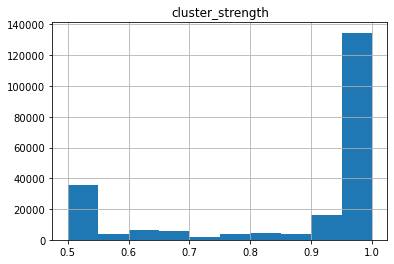

In [9]:
adj_mat[['cluster_strength']].hist('cluster_strength')



In [12]:
#adj_mat.groupby('cluster_src').min()

adj_mat_grouped = adj_mat.groupby([pd.Grouper(key='date', freq='D'),'cluster_src']).min()

In [13]:
adj_mat_grouped.sort_values('date').head(20)


,,src,dst,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst,cluster_strength
date,cluster_src,,,,,,,
2014-04-20,C7,[twitter_query=sol],[twitter_query=sol],1,1,0,C7,0.941677
2018-03-10,C7,[twitter_query=sol],[twitter_query=sol],1,1,0,C7,0.941677
2021-04-06,C7,[twitter_query=sol],[twitter_query=sol],9,9,0,C7,0.941677
2021-05-25,C0,ekir_de,ekir_de,1,1,0,C0,1.000000
2021-07-10,C3,azucaryjoon,azucaryjoon,1,1,0,C3,1.000000
2021-07-26,C7,ethereumonarm,ethereumonarm,7,7,0,C7,0.933333
2021-08-07,C7,[twitter_query=sol],[twitter_query=sol],1,1,0,C7,0.941677
2021-08-14,C6,buladude1,buladude1,1,1,0,C6,1.000000
2021-08-28,C7,[twitter_query=sol],[twitter_query=sol],2,2,0,C7,0.941677


In [15]:
adj_mat['cluster_strength'].min()

0.0

In [ ]:
#lowest value per cluster

for c in cluster_src:
    #return lowest value of cluster_strength
    print(min())

For the scores it is important to note that the lowest value indicates that there is no stimulation for a shock reaction.
In the model n = -1 means that there is the lowest possible amount of stimulation from the daily news sentiment whereas n = 1 means that there is the highest possible amount. 

## sentiment score

In [9]:
news_df = pd.read_excel('../GPT-3_Approach/output_data_sentiment.xlsx', index_col='Unnamed: 0').drop(columns=['Unnamed: 0.1','Unnamed: 0.1.1'])



In [10]:
news_df

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,Query,merge,sentiment,topic
0,Richard Lawler,A fake press release claiming Kroger accepts c...,A crypto hoax claimed Kroger is accepting Bitc...,https://www.theverge.com/2021/11/5/22765098/kr...,https://cdn.vox-cdn.com/thumbor/CKp0YjnwF88--m...,2021-11-05 13:32:14,A similar hoax earlier this year tied Walmart ...,the-verge,The Verge,bitcoin,A fake press release claiming Kroger accepts c...,Negative,NaN
1,mfox@businessinsider.com (Matthew Fox),An ethereum futures ETF will be available befo...,"""Though a spot Bitcoin ETF is possible in 2022...",https://markets.businessinsider.com/news/curre...,https://images2.markets.businessinsider.com/61...,2021-11-06 12:15:00,Ether.\nNurPhoto\n<ul><li>The approval of a bi...,business-insider,Business Insider,bitcoin,An ethereum futures ETF will be available befo...,Neutral,NaN
2,Entrepreneur Staff,Bitcoin Trades 7% Higher,Bitcoin was trading over 7% higher on Monday m...,https://www.entrepreneur.com/article/395938,https://assets.entrepreneur.com/content/3x2/20...,2021-11-08 16:07:45,Bitcoin was trading over 7% higher on Monday m...,NaN,Entrepreneur,bitcoin,Bitcoin Trades 7% Higher; Bitcoin was trading ...,Positive,NaN
3,NaN,Bitcoin hits new record as crypto market cap e...,Bitcoin and ether made record peaks in the Asi...,https://www.reuters.com/technology/bitcoin-hit...,https://www.reuters.com/resizer/InHvCiSZm4U-VU...,2021-11-08 23:38:00,A representation of the virtual cryptocurrency...,reuters,Reuters,bitcoin,Bitcoin hits new record as crypto market cap e...,Positive,NaN
4,Reuters Staff,Bitcoin hits new record as crypto market cap e...,Bitcoin and ether made record peaks in the Asi...,https://www.reuters.com/article/fintech-crypto...,https://static.reuters.com/resources/r/?m=02&d...,2021-11-08 23:37:00,By Reuters Staff\nFILE PHOTO: A representation...,reuters,Reuters,bitcoin,Bitcoin hits new record as crypto market cap e...,Positive,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,newsfeedback@fool.com (Adria Cimino),3 Reasons to Buy Cardano,Many catalysts are on the horizon.,https://www.fool.com/investing/2021/12/28/3-re...,https://g.foolcdn.com/editorial/images/658831/...,2021-12-28 11:00:00,There are thousands of cryptocurrencies out th...,NaN,Motley Fool,ethereum2,3 Reasons to Buy Cardano; Many catalysts are o...,Positive,NaN
1885,Paul Vigna,NFTs and SNL: Crypto Keeps Burrowing Into Main...,"It was another crazy year in the crypto world,...",https://www.wsj.com/articles/nfts-and-snl-cryp...,https://images.wsj.net/im-456771/social,2021-12-27 11:52:41,Crypto has been many things in its short histo...,the-wall-street-journal,The Wall Street Journal,ethereum2,NFTs and SNL: Crypto Keeps Burrowing Into Main...,Positive,NaN
1886,"Kenneth Rapoza, Senior Contributor, \n Kenneth...","Where To Put $1,000 In Your Cryptocurrency Por...",What will the hot sectors in cryptocurrency in...,https://www.forbes.com/sites/kenrapoza/2021/12...,https://thumbor.forbes.com/thumbor/fit-in/1200...,2021-12-29 13:30:00,What sectors of the crypto market should you c...,NaN,Forbes,ethereum2,"Where To Put $1,000 In Your Cryptocurrency Por...",Neutral,NaN
1888,Shaurya Malwa,Fantom Surges as Investors Seach for Next Laye...,FTM tokens are rallying even as the broader ma...,https://finance.yahoo.com/news/fantom-surges-i...,https://s.yimg.com/uu/api/res/1.2/hXU_4XMXUJ76...,2021-12-29 09:23:05,Tokens of layer 1 blockchain Fantom (FTM) were...,NaN,Yahoo Entertainment,ethereum2,Fantom Surges as Investors Seach for Next Laye...,Positive,NaN


## indicator score

In [2]:
df_ta


,Date,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
Date,,,,,,,,
2017-02-09,2017-02-09,994.382996,407220000,0,0,-2,-2,-1.0
2017-02-10,2017-02-10,988.674011,190452000,0,0,-2,-2,-1.0
2017-02-11,2017-02-11,1004.450012,102261000,0,0,2,-2,-0.2
2017-02-12,2017-02-12,999.181030,67530000,0,0,-2,-2,-1.0
2017-02-13,2017-02-13,990.642029,100607000,0,0,-2,-2,-1.0
...,...,...,...,...,...,...,...,...
2022-01-16,2022-01-16,43113.878906,17902097845,0,0,-2,-2,-1.0
2022-01-17,2022-01-17,42250.550781,21690904261,0,0,-2,-2,-1.0
2022-01-18,2022-01-18,42375.632812,22417209227,0,0,2,-2,-0.2


In [12]:
df_ta = df_ta.loc['2021-10-21':'2021-12-31']
df_ta

,Date,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
Date,,,,,,,,
2021-10-21,2021-10-21,62210.171875,45908121370,0,0,-2,2,0.2
2021-10-22,2021-10-22,60692.265625,38434082775,0,0,-2,2,0.2
2021-10-23,2021-10-23,61393.617188,26882546034,0,0,2,2,1.0
2021-10-24,2021-10-24,60930.835938,27316183882,0,0,-2,2,0.2
2021-10-25,2021-10-25,63039.824219,31064911614,0,0,2,2,1.0
...,...,...,...,...,...,...,...,...
2021-12-27,2021-12-27,50640.417969,24324345758,0,0,-2,-2,-1.0
2021-12-28,2021-12-28,47588.855469,33430376883,0,0,-2,-2,-1.0
2021-12-29,2021-12-29,46444.710938,30049226299,0,0,-2,-2,-1.0


In [13]:
df_ta.describe()

,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
count,72.000000,7.200000e+01,72.0,72.000000,72.000000,72.000000,72.000000
mean,55819.096300,3.340240e+10,0.0,0.027778,-0.222222,0.055556,-0.019444
std,6487.504301,7.198025e+09,0.0,0.530007,2.001564,2.013258,0.688873
min,46202.144531,1.903065e+10,0.0,-2.000000,-2.000000,-2.000000,-1.000000
25%,49367.262695,2.819713e+10,0.0,0.000000,-2.000000,-2.000000,-0.400000
50%,57117.626953,3.249791e+10,0.0,0.000000,-2.000000,2.000000,0.200000
75%,61337.622070,3.703018e+10,0.0,0.000000,2.000000,2.000000,0.200000
max,67566.828125,6.138568e+10,0.0,2.000000,2.000000,2.000000,1.000000


## model payoffs

The mathematical basis for the cascade model provides a logistic function (I). In addition to the current date, news sentiment and indicator scores are summed up and serve as model input. Based on (I) the model calculates the perceived payoffs for strategy A and strategy B. These payoff values function as global parameters for the whole network, implying that every node inside the network perceives the respective payoffs in the same way. 


A crucial design decision that has been made is that the payoff for strategy B is the counter-calue of the payoff for strategy B. This decision should emphasize that strategy B is simply the absence of strategy A. Therefore, the inequality (II), which decides whether or not a complete strategy A cascade is possible, is reduced to (II.1). In order for a complete strategy A cascade to be hence possible, inside the network on a specific date, there cannot exist a cluster with a cluster strength p greater than a.

- I: equality for payoff a
- II: inequality for complete cascade p > 1 - b
- II.1: p > a

In [39]:
# model_payoffs:

## input:
### x --> linear combination of scores
### date
## output:
### payoff a --> a = 1/(1+exp(-x)), per day
### payoff b --> b = 1 - a, per day

# strategy A --> shock reaction (hype/panic)
# strategy B --> indifferent reaction

# threshold:

## input:
### payoff for strategy a
### payoff for strategy b
## output:
### threshold value q --> q = b / (a + b)


max cluster strength p has to be greater than a (p>a) for strategy A to cause a complete cascade

- this is because b = 1 - a and q = b/(a+b) (--> a+b = 1 --> q = b/1)

- original threshold formula: p > 1 - q --> p > 1 - b --> p > a (--> b=1-a --> a=1-b)

- so in order for a cluster to break a complete strategy A cascade it has to have a strength greater than a

In [38]:
import math


d = ['november']
n = -1
t = -1

def cascade_model(date, news, ta):
    
    #sum of scores
    x = news + ta
    
    #payoffs
    a = 1 / (1 + math.exp(-x))
    b = 1 - a
    
    #threshold
    q = b / (a + b)
    
    #output
    model_output_dict = {}
    
    for d in date:
        model_output_dict[d] = [(a,b), 1 - q]
                                
    return model_output_dict

cascade_model(date=d, news=n, ta=t)

{'november': [(0.11920292202211755, 0.8807970779778824), 0.11920292202211757]}